In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import os
import numpy as np

2025-07-15 17:37:00.244571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752601020.616819      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752601020.722553      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
conv_base = MobileNetV2(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

I0000 00:00:1752601040.606304      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752601040.607046      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [4]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

In [5]:
# Define data augmentation
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.2),
    # layers.RandomTranslation(0.2, 0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.3),
])


In [6]:
# Load dataset from input/fold
dataset_path = "/kaggle/input/refined-model-data/dataset_1/preprocessed_original_images/"
img_height = 224
img_width = 224
batch_size = 40

dataset = keras.utils.image_dataset_from_directory(
    directory=dataset_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 847 files belonging to 6 classes.


In [7]:
# Split dataset into train (80%) and test (20%)
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Further split train_dataset into train (80%) and validation (20%)
val_size = int(0.2 * train_size)
train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)

In [8]:
# Function to apply augmentation and normalization to training data
def process_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = data_augmentation(image)            # Apply augmentation
    return image, label

# Function to normalize validation and test data
def process_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

In [9]:
# Apply processing functions
train_dataset = train_dataset.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [10]:
# Load VGG16 base model
conv_base = keras.applications.MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3))

In [11]:
# Unfreeze top 30 layers
for layer in conv_base.layers[-40:]:
    layer.trainable = True

In [12]:
# Define model-building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(6, activation='softmax'))  # 4 classes
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-1, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [13]:
# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_dir_mobilenetv2',
    project_name='mobilenetv2_classification'
)
# Search for best hyperparameters
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    # class_weight=class_weights
)

Trial 10 Complete [00h 01m 20s]
val_accuracy: 0.23333333432674408

Best val_accuracy So Far: 0.675000011920929
Total elapsed time: 00h 13m 24s


In [14]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Create output directory
output_dir = 'mobilenetv2/'
os.makedirs(output_dir, exist_ok=True)

Best units: 384
Best learning rate: 9.854379441557013e-05


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# Save the best model and weights
best_model.save(os.path.join(output_dir, 'best_model.keras'))
best_model.save_weights(os.path.join(output_dir, 'best_model_weights.weights.h5'))

# Define callbacks for further training
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(output_dir, 'best_finetuned_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)


In [16]:
# Further train the best model
history = best_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    # class_weight=class_weights,
    # callbacks=[checkpoint]
)



Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 383ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.6333 - val_loss: 1.1864
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.6333 - val_loss: 1.3289
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.6167 - val_loss: 1.3327
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.3057e-04 - val_accuracy: 0.6833 - val_loss: 1.1919
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.9567e-04 - val_accuracy: 0.6917 - val_loss: 1.1758
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9065e-04 - val_accuracy: 0.7083 - val_loss: 1.1801
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.1053e-04 - val_accuracy: 0.7083 - val_loss: 1.1884
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 

In [21]:
# Evaluate the model on test dataset
loss, accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7237 - loss: 1.3187
Test Loss: 1.3220
Test Accuracy: 0.7305


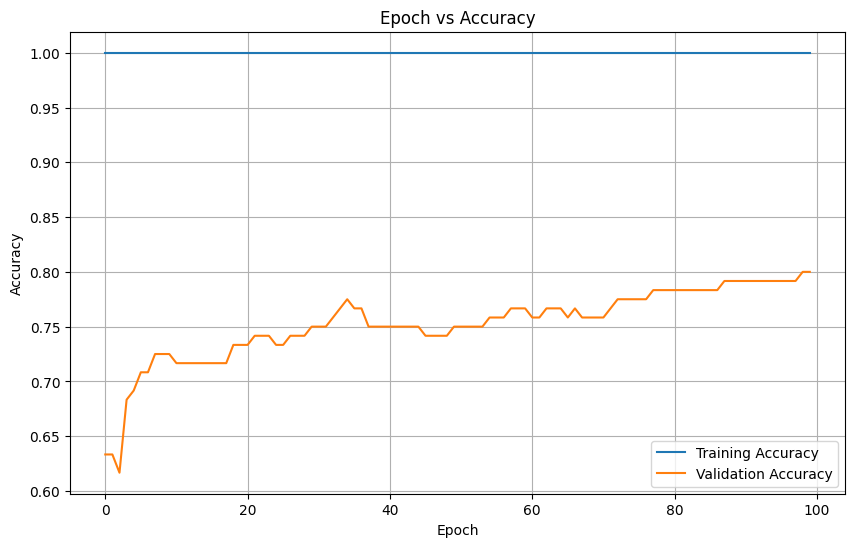

In [18]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/kaggle/working/mobilenetv2/accuracy_plot.png')
plt.show()

In [19]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │       491,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,188,372 (31.24 MB)

 Trainable params: 2,718,086 (10.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 5,436,174 (20.74 MB)

In [23]:
dataset.class_names

['chickenpox', 'cowpox', 'healthy', 'measles', 'monkeypox', 'smallpox']

In [24]:
# --- Evaluation Metrics ---
# Collect true labels and predictions from the test dataset
from sklearn.metrics import classification_report

y_true = []
y_pred = []
y_pred_proba = []
class_names=dataset.class_names

for images, labels in test_dataset.unbatch():
    y_true.append(labels.numpy())
    predictions = best_model.predict(images[None, ...], verbose=0)
    y_pred.append(np.argmax(predictions, axis=1)[0])
    y_pred_proba.append(predictions[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

  chickenpox       0.55      0.76      0.64        29
      cowpox       0.64      0.58      0.61        12
     healthy       0.89      1.00      0.94         8
     measles       0.67      0.44      0.53         9
   monkeypox       0.90      0.50      0.64        38
    smallpox       0.78      0.87      0.82        71

    accuracy                           0.73       167
   macro avg       0.74      0.69      0.70       167
weighted avg       0.76      0.73      0.72       167



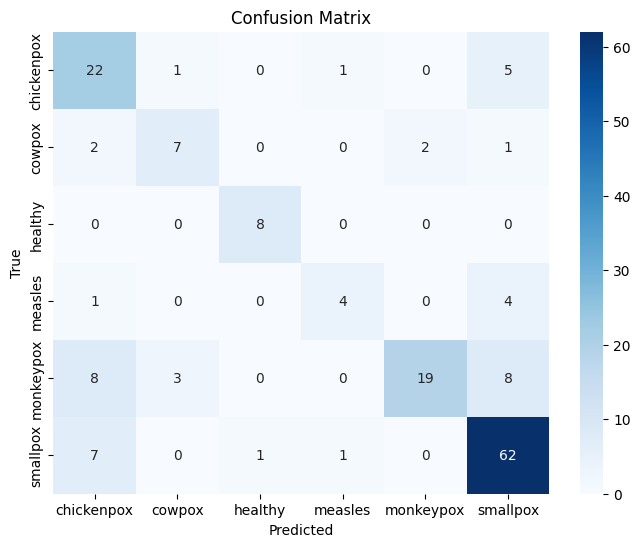

In [25]:
# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

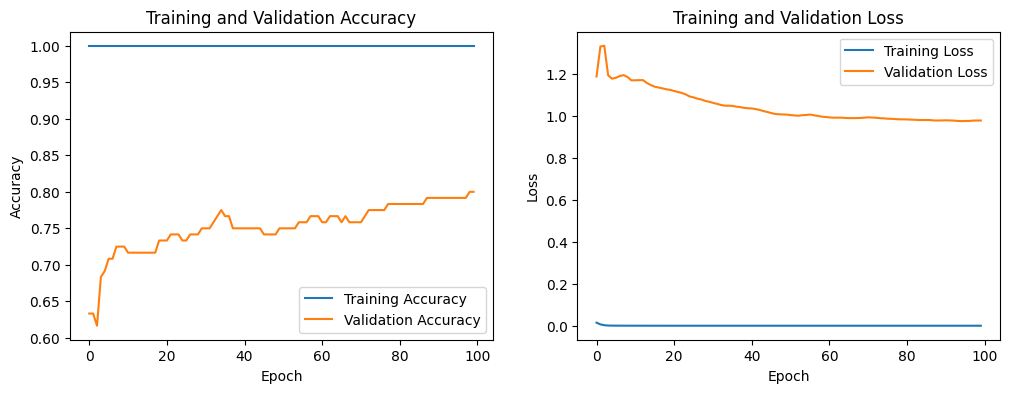

In [26]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

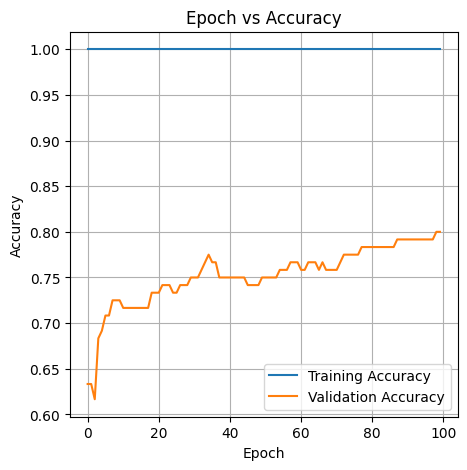

In [27]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/kaggle/working/mobilenetv2/accuracy_plot.png')
plt.show()